In [50]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 
from tqdm import tqdm
import random

import warnings
warnings.filterwarnings("ignore")


os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers

import numpy as np
import collections
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import LearningRateSchedule


# Load Data

https://www.kaggle.com/datasets/orvile/gastric-cancer-histopathology-tissue-image-dataset

This dataset comprises 31,096 non-overlapping images, each with a size of 224x224 pixels. These images were extracted from H&E-stained pathological slides of human gastric cancer obtained from Harbin Medical University Cancer Hospital. 

The dataset focuses on the tumor microenvironment (TME) and includes images categorized into eight distinct tissue types:

    ADI: Adipose (fat tissue)
    DEB: Debris (cellular waste) 
    LYM: Lymphocytes (immune cells)
    MUC: Mucus (protective secretion)
    MUS: Smooth Muscle (muscle tissue)
    NORM: Normal Colon Mucosa (healthy tissue for reference)
    STR: Cancer-associated Stroma (connective tissue around the tumor)
    TUM: Tumor (cancerous tissue) 
    
    

In [51]:
path = "Data/HMU-GC-HE-30K/all_image"
tissue_types = os.listdir(path)
tissue_types.sort()

In [52]:
tissue_types

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

Lets plot some images for each tissue types

ADI


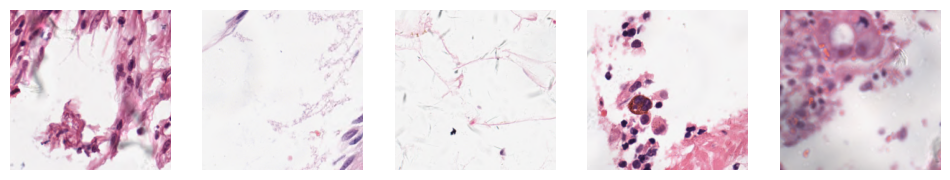

DEB


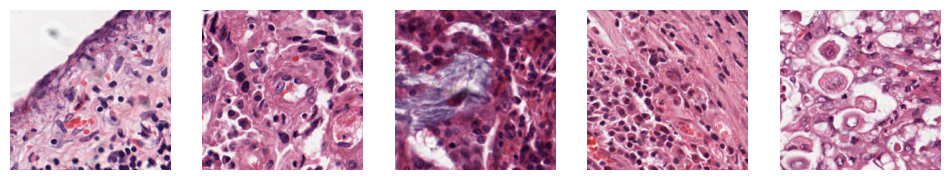

LYM


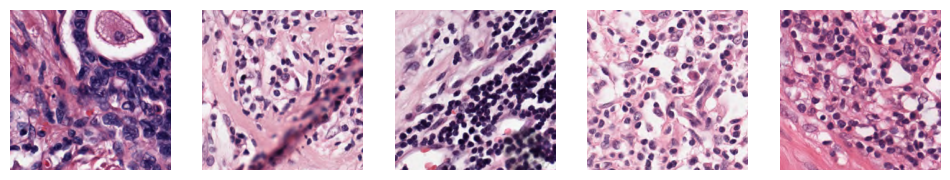

MUC


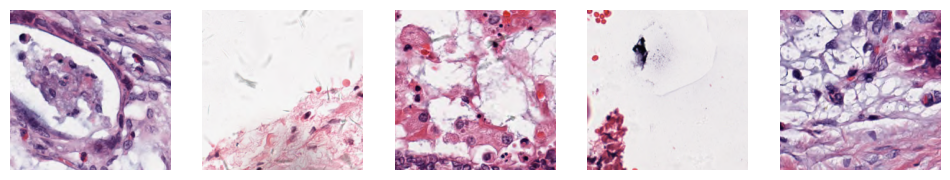

MUS


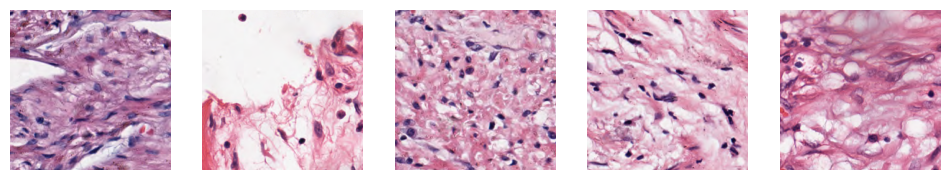

NOR


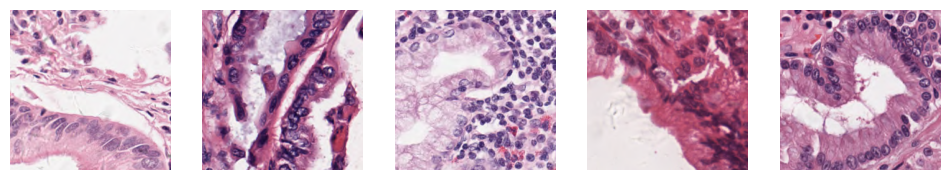

STR


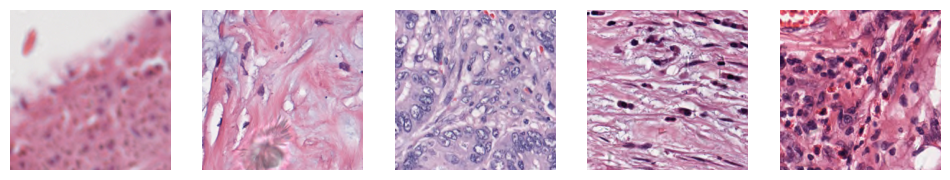

TUM


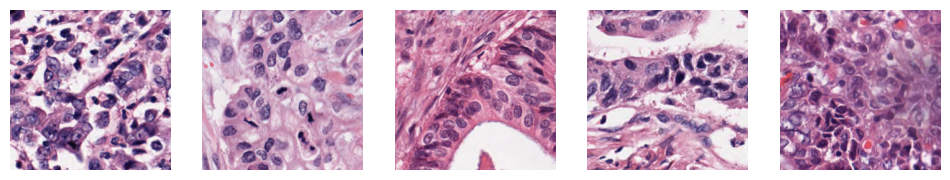

In [53]:
images_per_label = 5
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    folder_files = os.listdir(folder_path)
    random_ind=np.random.randint(0, len(folder_files),images_per_label)
    fig, ax = plt.subplots(1, images_per_label, figsize=(12, 10))
    print(tissue)
    for i, ind in enumerate(random_ind):     
        img = plt.imread(folder_path+'/'+folder_files[ind])
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()



In [54]:
for tissue in tissue_types:
    folder_path = os.path.join(path, tissue)
    if os.path.isdir(folder_path):
        num_images = len([f for f in os.listdir(folder_path)])
        print(f"{tissue}: {num_images} images")

ADI: 3587 images
DEB: 3587 images
LYM: 3587 images
MUC: 3587 images
MUS: 3587 images
NOR: 3587 images
STR: 3587 images
TUM: 3587 images


# Create a train and validation dataset

In [55]:
# 85-15 split 

train_ds,val_ds = tf.keras.utils.image_dataset_from_directory(
  path,
  labels='inferred',
  validation_split=0.15,
  subset='both',
  seed=85,
  batch_size=16,
  image_size=(224, 224),
  shuffle=True
  )


Found 28696 files belonging to 8 classes.
Using 24392 files for training.
Using 4304 files for validation.


To make sure we have the datasets as intended we can visualize the class names.

In [56]:
train_ds.class_names

['ADI', 'DEB', 'LYM', 'MUC', 'MUS', 'NOR', 'STR', 'TUM']

 We can also fetch one batch of images and labels in the train dataset and look at the shape.

In [57]:
image, label = next(iter(train_ds))
print(image.shape)
print(label.shape)

(16, 224, 224, 3)
(16,)


In [58]:
train_labels = []
for _, labels in train_ds:
    train_labels.extend(labels.numpy())

train_label_counts = collections.Counter(train_labels)
print("Train label distribution:")
print(dict(sorted(train_label_counts.items())))

val_labels = []
for _, labels in val_ds:
    val_labels.extend(labels.numpy())

val_label_counts = collections.Counter(val_labels)
print("\nValidation label distribution:")
print(dict(sorted(val_label_counts.items())))

Train label distribution:
{0: 3078, 1: 3031, 2: 3063, 3: 3068, 4: 3034, 5: 3035, 6: 3060, 7: 3023}

Validation label distribution:
{0: 509, 1: 556, 2: 524, 3: 519, 4: 553, 5: 552, 6: 527, 7: 564}


The sample distributions look reasonably balanced across train, test, and validation sets which is good. 

In [59]:
num_labels=len(train_ds.class_names)

In [65]:
# use buffered prefetching for performance
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)


In [33]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
# ])

In [62]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0

input_tensor = tf.keras.Input(shape=(224, 224, 3))

#x = data_augmentation(input_tensor)
#x = layers.Rescaling(1./255)(x)

x = layers.Rescaling(1./255)(input_tensor)

base_model_1 = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=x)
x = base_model_1.output

x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)  # matches .flatten(start_dim=1) in PyTorch
x = layers.Dropout(0.3)(x)
output_tensor = layers.Dense(8, activation='softmax')(x)

model = models.Model(inputs=input_tensor, outputs=output_tensor)



In [43]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
#     tf.keras.layers.Conv2D(32, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(64, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Conv2D(128, 3, activation='relu'),
#     tf.keras.layers.MaxPooling2D(),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dense(num_labels, activation='softmax')
# ])


In [35]:
# for layer in base_model.layers:
#     layer.trainable = False
# for layer in base_model.layers[-20:]:
#     layer.trainable = True

In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    min_delta=0.005, # minimium amount of change to count as an improvement
    patience=16, # how many epochs to wait before stopping
    restore_best_weights=True
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

In [66]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
#optimizer = tf.keras.optimizers.legacy.AdamW(learning_rate=1e-4,weight_decay=1e-4)

model.compile(optimizer=optimizer,loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
              ,metrics=['accuracy'])

history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[early_stopping, checkpoint_callback])

Epoch 1/20
  60/1525 [>.............................] - ETA: 1:18:52 - loss: 2.0440 - accuracy: 0.1708

KeyboardInterrupt: 